# Прогнозирование заказов такси

## Описание проекта

### Описание данных

* Имеются исторические данные о заказах такси в аэропортах. 
* Нужно построить модель для прогнозирования количества заказов такси на следующий час. 
* Значение метрики RMSE на тестовой выборке должно быть не больше 48.

### План

* Загрузить данные и выполнить их ресемплирование по одному часу.
* Проанализировать данные.
* Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
* Проверить данные на тестовой выборке и сделайте выводы.

## Инициализация констант и импорты библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.dummy import DummyRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from typing import Literal

In [2]:
RANDOM_STATE = 12345

## Загрузка и предобработка данных

### Загрузка и изучение данных

In [3]:
try:
    data = pd.read_csv('../../datasets/taxi.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv')

In [4]:
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')
data.set_index('datetime', inplace=True)

In [5]:
data.sort_index(inplace=True)

In [6]:
data.index.is_monotonic_increasing

True

In [7]:
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [9]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


### Предобработка данных

In [10]:
data.isna().sum()

num_orders    0
dtype: int64

Дубликаты в таких данных искать нет смысла, это могут быть просто повторяющиеся значения в разное время.

In [11]:
data = data.resample('1H').sum()
data.head()

C:\Users\klpkv\AppData\Local\Temp\ipykernel_22564\1331465909.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data = data.resample('1H').sum()


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [12]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


### Выводы по разделу

* Колонку с датой и временем изменил на тип datetime и сделал индексом.
* Отсортировал индексы в хронологическом порядке.
* Пропусков в данных нет.
* Ресемплировал данные по 1 часу.

## Анализ данных

### Проверка выбросов в данных

<AxesSubplot:ylabel='Frequency'>

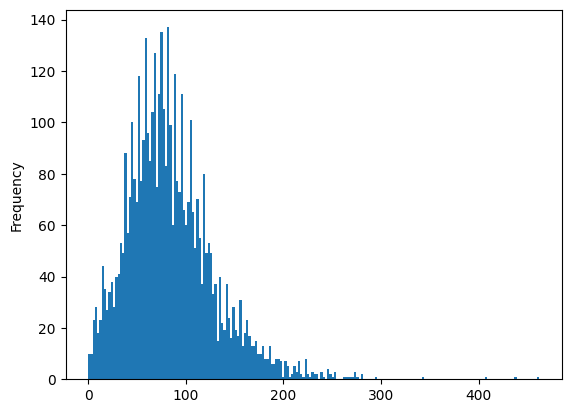

In [13]:
data['num_orders'].plot(kind='hist', bins=200)

В данных видны выбросы (после 280 прочти нет значений)

<AxesSubplot:xlabel='datetime'>

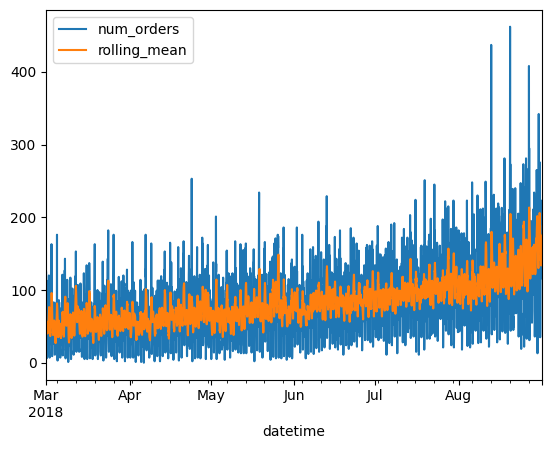

In [14]:
data['rolling_mean'] = data['num_orders'].rolling(10).mean() 
data.plot()

### Тренд и сезонность

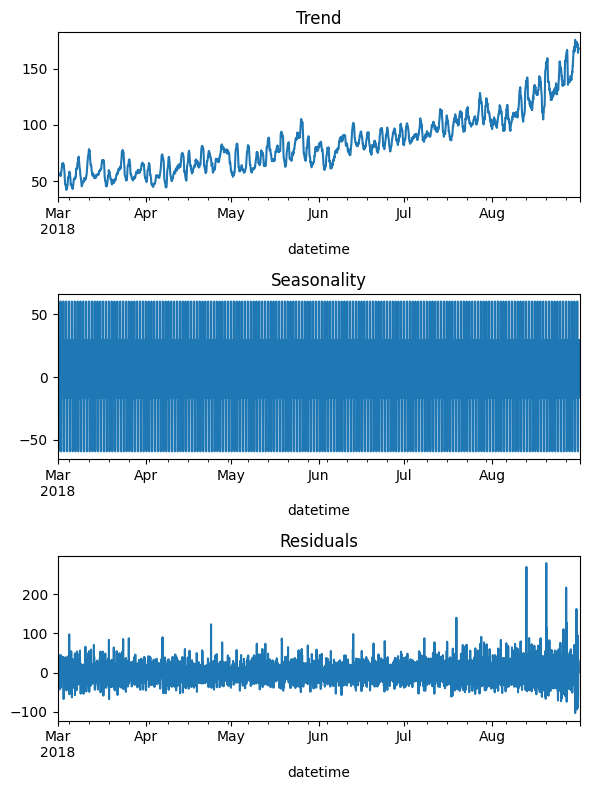

In [15]:
decomposed = seasonal_decompose(data['num_orders'])

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

* В данных прослеживается восходящий тренд.
* Видимо в данных несколько сезонностей, поэтому стандартным инструментом не получилось их все вытащить.

In [16]:
data['mean'] = data['num_orders'].rolling(15).mean()
data['std'] = data['num_orders'].rolling(15).std()

<AxesSubplot:xlabel='datetime'>

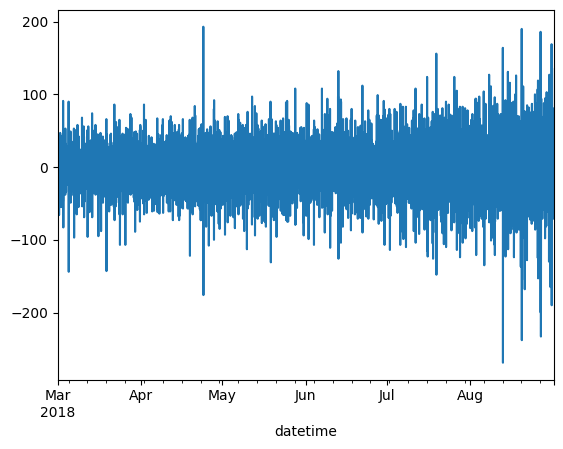

In [17]:
data['diff'] = data['num_orders'] - data['num_orders'].shift()
data['diff'].plot()

In [18]:
(
    data[['num_orders']]
    .quantile([0.0012, 0.05, .5, .95, .9988])
    .style.format("{:,.2f}")
)

,num_orders
0.001200,2.00
0.050000,21.00
0.500000,78.00
0.950000,166.00
0.998800,281.00


### Вывод по разделу

* В данных видны выбросы (после 280 прочти нет значений)
* В данных прослеживается восходящий тренд.
* Видимо в данных несколько сезонностей, поэтому стандартным инструментом не получилось их все вытащить.

## Обучение моделей

### Погдотовка данных к обучению

In [19]:
train, test = train_test_split(pd.DataFrame(data['num_orders'], index=data.index), shuffle=False, test_size=.1)

In [20]:
data.index

DatetimeIndex(['2018-03-01 00:00:00', '2018-03-01 01:00:00',
               '2018-03-01 02:00:00', '2018-03-01 03:00:00',
               '2018-03-01 04:00:00', '2018-03-01 05:00:00',
               '2018-03-01 06:00:00', '2018-03-01 07:00:00',
               '2018-03-01 08:00:00', '2018-03-01 09:00:00',
               ...
               '2018-08-31 14:00:00', '2018-08-31 15:00:00',
               '2018-08-31 16:00:00', '2018-08-31 17:00:00',
               '2018-08-31 18:00:00', '2018-08-31 19:00:00',
               '2018-08-31 20:00:00', '2018-08-31 21:00:00',
               '2018-08-31 22:00:00', '2018-08-31 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=4416, freq='h')

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3974 entries, 2018-03-01 00:00:00 to 2018-08-13 13:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  3974 non-null   int64
dtypes: int64(1)
memory usage: 62.1 KB


In [22]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


In [23]:
make_features(train, 50, 10)
train.dropna(inplace=True)
make_features(test, 50, 10)
test.dropna(inplace=True)

In [24]:
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

### Работа с моделями

In [25]:
# Класс для работы с моделями
class MultiModelLearning:
    def __init__(self, model_name: Literal['linear_regressor', 'tree', 'bagging', 'boosting', 'dummy', 'ANN']):
        self.model_name = model_name
        if model_name == 'linear_regressor':
            self.model = LinearRegression()
        elif model_name == 'tree':
            self.model = DecisionTreeRegressor(random_state=RANDOM_STATE)
        elif model_name == 'bagging':
            self.model = BaggingRegressor(random_state=RANDOM_STATE)
        elif model_name == 'boosting':
            self.model = LGBMRegressor(random_state=RANDOM_STATE)
        elif model_name == 'dummy':
            self.model = DummyRegressor(strategy="mean")
        elif model_name == 'ANN':
            self.model = MLPRegressor(random_state=RANDOM_STATE, solver='sgd', activation='logistic', shuffle=False)
        else:
            display("Было введено неверное имя модели")
        self.features = None
        self.target = None
        self.best_model = None
        self.best_score = None
        self.best_params = None

    # Подбор гиперпараметров для модели
    def select_hyperparameters__(self, param_dist):
        grid_search = GridSearchCV(self.model, param_grid=param_dist, cv=5, scoring='neg_root_mean_squared_error')
        grid_search.fit(self.features, self.target)
        self.best_model = grid_search.best_estimator_
        self.hyperparameters = grid_search.best_params_
        self.best_score = -grid_search.best_score_

    # Функции обучения моделей
    def learn_linear_regression__(self): 
        # self.best_score = -sum(cross_val_score(self.model, self.features, self.target, cv=5, scoring='neg_root_mean_squared_error'))/5
        param_dist = {}
        self.select_hyperparameters__(param_dist)
    
    def learn_tree__(self):
        param_dist = {
            'max_depth': [i for i in range(1,15)]
        }
        self.select_hyperparameters__(param_dist)

    def learn_bagging__(self):
        param_dist = {
            'n_estimators': [i for i in range(1, 8)],
        }
        self.select_hyperparameters__(param_dist)
        
    def learn_boosting__(self):
        param_dist = {
            'n_estimators': [2,5,10,25,50,100],
            'learning_rate': [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
        }
        self.select_hyperparameters__(param_dist)

    def learn_dummy__(self):
        self.best_model = self.model.fit(self.features, self.target)
        self.best_score = -sum(cross_val_score(self.model, self.features, self.target, cv=5, scoring='neg_root_mean_squared_error'))/5

    def learn_ANN__(self):
        param_dist = {
            'learning_rate_init': [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001],
            'hidden_layer_sizes': [[i for i in range(5, 20)], [[i, i+1] for i in range(5, 20)]]
        }
        self.select_hyperparameters__(param_dist)

    def learn_dummy__(self):
        self.best_model = self.model.fit(self.features, self.target)
        self.best_score = -sum(cross_val_score(self.model, self.features, self.target, cv=5, scoring='neg_root_mean_squared_error'))/5


    def select_model__(self):
        if self.model_name == 'linear_regressor':
            self.learn_linear_regression__()
        elif self.model_name == 'tree':
            self.learn_tree__()
        elif self.model_name == 'bagging':
            self.learn_bagging__()
        elif self.model_name == 'boosting':
            self.learn_boosting__()
        elif self.model_name == 'dummy':
            self.learn_dummy__()
        elif self.model_name == 'ANN':
            self.learn_ANN__()
        else:
            display("Было введено неверное имя модели")

    def fit(self, features, target):
        self.features = features
        self.target = target
        self.select_model__()


    # Предсказание модели
    def predict(self, features):
        model_predictions = self.best_model.predict(features)
        return model_predictions

### Обучение моделей

In [26]:
linear_regression = MultiModelLearning('linear_regressor')
linear_regression.fit(X_train, y_train)
linear_regression.best_score

23.54334103502736

In [27]:
tree = MultiModelLearning('tree')
tree.fit(X_train, y_train)
tree.best_score

26.677249282821833

In [28]:
boosting = MultiModelLearning('boosting')
boosting.fit(X_train, y_train)
boosting.best_score

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9614
[LightGBM] [Info] Number of data points in the train set: 3139, number of used features: 54
[LightGBM] [Info] Start training from score 83.995540
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9576
[LightGBM] [Info] Number of data points in the train set: 3139, number of used features: 54
[LightGBM] [Info] Start training from score 81.726346
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9492
[LightGBM] [Info] Number of data points in the train set: 3139, number of used features: 54
[LightGBM] [Info] Start trai

22.84918577492354

In [29]:
bagging = MultiModelLearning('bagging')
bagging.fit(X_train, y_train)
bagging.best_score

25.012523344322464

In [30]:
dummy = MultiModelLearning('dummy')
dummy.fit(X_train, y_train)
dummy.best_score

40.13254433114581

### Выводы по разделу

* Данные были разбиты на обучающие и тестовые в соотношении 9:1.
* Для обучения были выбраны модели: линейной регрессии, решабщего дерева, бэггинга, бустинга.
* Лучше всего себя показала модель бустинга со значением RMSE равным 23.

## Проверка лучшей модели

In [31]:
predict = boosting.predict(X_test)
root_mean_squared_error(predict, y_test)

41.162659943716626

### Выводы по разделу

* Лучшая модель показывает нужные результаты метрики.
* RMSE на обучающих данных значительно ниже чем на тестовых, что говорит о переобучении модели.
* Возмонжо имеет смысл посчитать производные в каждой точке и обучать модели предсказывать их а не саму функцию, это должно улучшить качество нелинейных моделей. 
* Также можно отмаштабировать данные, это также может помочь улучшить метрики моделей.

## Общий вывод

* Предобработка данных:

    * Колонку с датой и временем изменил на тип datetime и сделал индексом.
    * Отсортировал индексы в хронологическом порядке.
    * Пропусков в данных нет.
    * Ресемплировал данные по 1 часу.

* Анализ данных

    * В данных видны выбросы (после 280 прочти нет значений)
    * В данных прослеживается восходящий тренд.
    * Видимо в данных несколько сезонностей, поэтому стандартным инструментом не получилось их все вытащить.

* Работа с моделями:

    * Данные были разбиты на обучающие и тестовые в соотношении 9:1.
    * Для обучения были выбраны модели: линейной регрессии, решабщего дерева, бэггинга, бустинга.
    * Лучше всего себя показала модель бустинга со значением RMSE равным 23.
    * Лучшая модель показывает нужные результаты метрики.


* Общий вывод и репомендации:

    * Создана модель для прогнозирования количества заказов на следующий час.
    * Метрика RMSE модели на тестовых данных равна 41.
    * Возмонжо имеет смысл посчитать производные в каждой точке и обучать модели предсказывать их а не саму функцию, это должно улучшить качество нелинейных моделей. 
    * RMSE на обучающих данных значительно ниже чем на тестовых, что говорит о переобучении модели.
    * Также можно отмаштабировать данные, это также может помочь улучшить метрики моделей.